# NBA Statistics Clustering Project
# Unsupervised Learning Final (CU-Boulder MSDS)
### by: Kevin Boyle

## Problem Description

Hello! For this project, I am going to read in a data set with NBA (National Basketball Association) player information and performance statistics. 

I got this data set from the following Kaggle link: https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats?select=Player+Per+Game.csv

With this data set, I am going to try to see if I can use unsupervised learning techniques, in particular PCA and different types of clustering, to see if I can predict what position the basketball player plays given the statistics that are presented in the data.

Because the NBA has changed over time (for example, there was no 3-point line until 1979), I will only look back 10 years. Since this data has every player since 1949, it should not be too difficult to narrow it down and still get sufficient data.

I am going to perform exploratory data analysis and visualization and do any necessary cleaning of the data, and then create a clustering model which will analyze the cleaned data. From there, I will conclude whether or not clustering is a good enough metric for this purpose and for this dataset.

Enjoy!

## EDA Procedure

To start, I will import all necessary libraries and load in the player information data set.

In [25]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
nba = pd.read_csv("Player Per Game.csv")

In [3]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31135 entries, 0 to 31134
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seas_id        31135 non-null  int64  
 1   season         31135 non-null  int64  
 2   player_id      31135 non-null  int64  
 3   player         31135 non-null  object 
 4   birth_year     2868 non-null   float64
 5   pos            31135 non-null  object 
 6   age            31113 non-null  float64
 7   experience     31135 non-null  int64  
 8   lg             31135 non-null  object 
 9   tm             31135 non-null  object 
 10  g              31135 non-null  int64  
 11  gs             22498 non-null  float64
 12  mp_per_game    30052 non-null  float64
 13  fg_per_game    31135 non-null  float64
 14  fga_per_game   31135 non-null  float64
 15  fg_percent     30986 non-null  float64
 16  x3p_per_game   24783 non-null  float64
 17  x3pa_per_game  24783 non-null  float64
 18  x3p_pe

In [4]:
nba['season'].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002,
       2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991,
       1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980,
       1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969,
       1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958,
       1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948, 1947])

From these few commands, I can see some important information. 
* I can see that there are 31,355 total players in the database.
* There are null values scattered throughout, mostly in birth year. Fortunately, birth year is not really a statistic that I will be tracking, so I will be able to drop that column.
* I suspect a lot of the other null values related to statistics might have to do with the fact that certain statistics were not tracked before a certain year. For example, like I said, the 3-point line was not introduced until 1979, so players who played their entire career before then would not have valid 3-point statistics.
* This is a data set from 1947 - 2023, so I will only consider the past 10 seasons, so I will create a new data set (new_nba) that only includes data from 2014 - 2023. I will then explore some of that data.

In [5]:
new_nba = nba.loc[(nba['season'] >= 2014) & (nba['season'] <= 2023)]

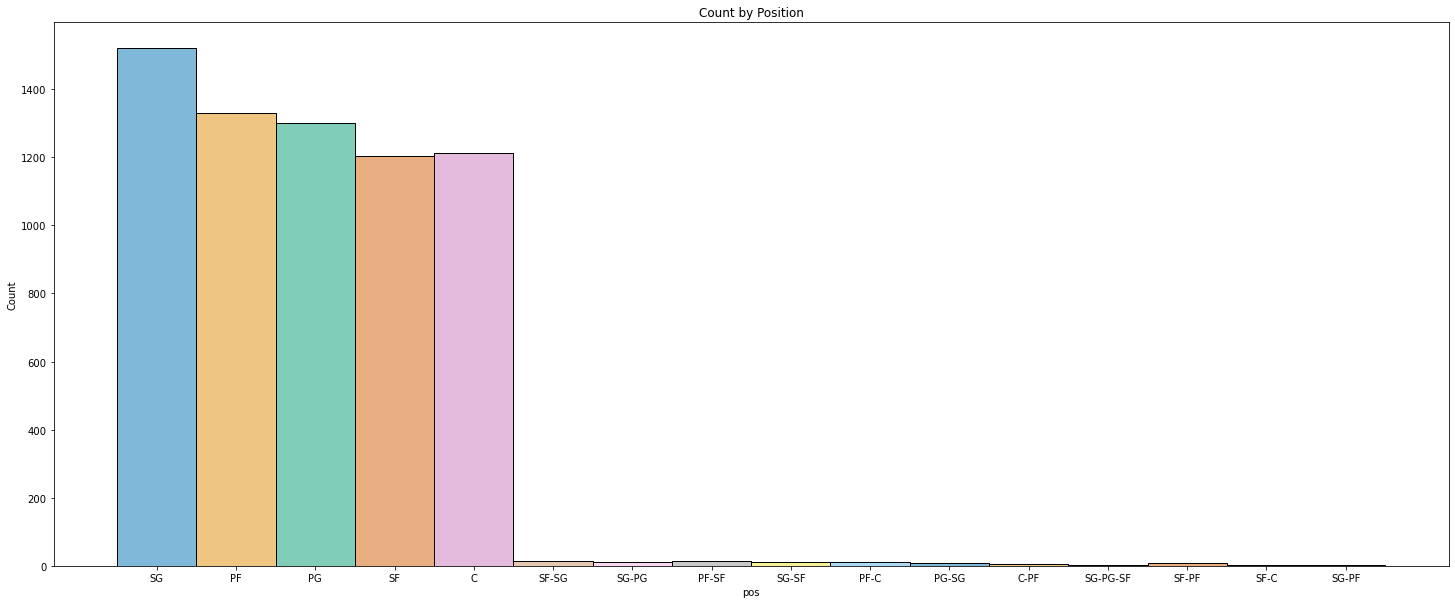

In [6]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.histplot(
    data = new_nba,
    x = 'pos',
    hue = 'pos',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Count by Position');

From this visualization, I can see that in addition to the five standard positions in basketball, there are 11 "hybrid" positions in the data set that a handful of players are each occupying. For the purposes of this project and this model, I will drop those players from the data set so that we get cleaner data with only five positions.

In [7]:
new_nba = new_nba.loc[(new_nba['pos'].isin(['SG','PF','PG','SF','C']))]

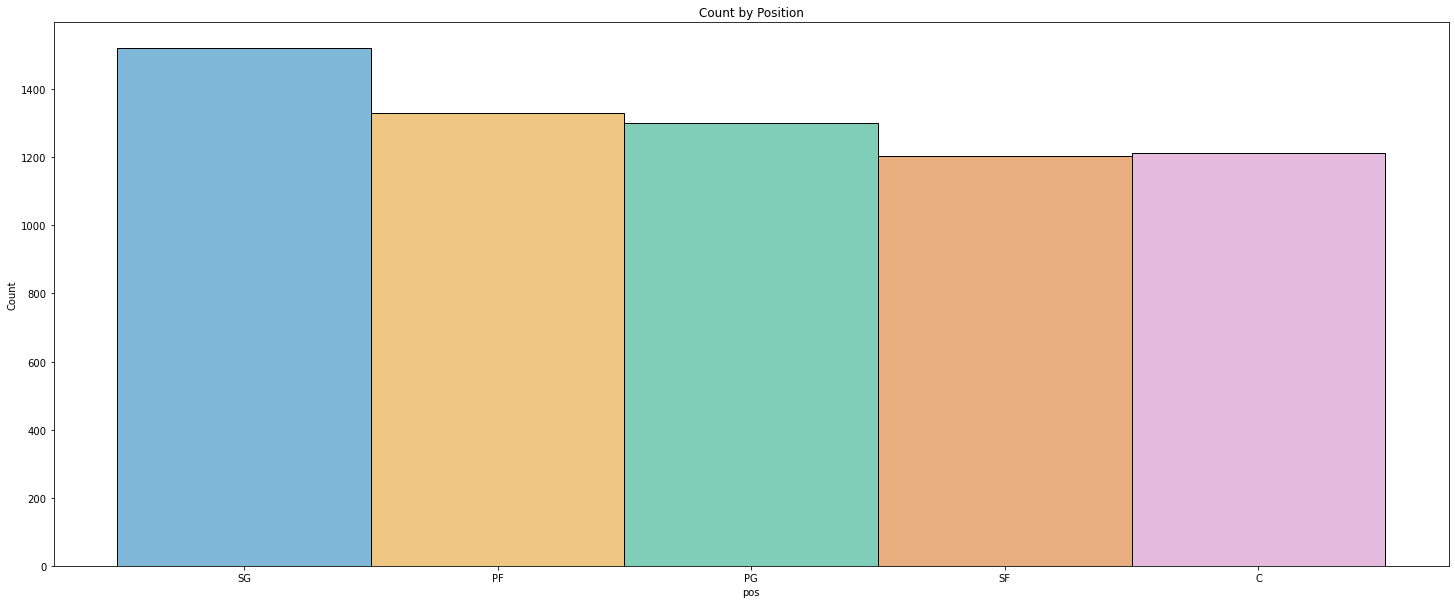

In [8]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.histplot(
    data = new_nba,
    x = 'pos',
    hue = 'pos',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Count by Position');

That's better! One last thing I am going to do is to deal with the null values within the statistics.

In [9]:
new_nba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6570 entries, 0 to 6652
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seas_id        6570 non-null   int64  
 1   season         6570 non-null   int64  
 2   player_id      6570 non-null   int64  
 3   player         6570 non-null   object 
 4   birth_year     43 non-null     float64
 5   pos            6570 non-null   object 
 6   age            6570 non-null   float64
 7   experience     6570 non-null   int64  
 8   lg             6570 non-null   object 
 9   tm             6570 non-null   object 
 10  g              6570 non-null   int64  
 11  gs             6570 non-null   float64
 12  mp_per_game    6570 non-null   float64
 13  fg_per_game    6570 non-null   float64
 14  fga_per_game   6570 non-null   float64
 15  fg_percent     6524 non-null   float64
 16  x3p_per_game   6570 non-null   float64
 17  x3pa_per_game  6570 non-null   float64
 18  x3p_perc

Like I said, I am going to drop birth_year, and after that, I see there are 5 additional columns with null values:
* fg_percent
* x3p_percent
* x2p_percent
* e_fg_percent
* ft_percent

In order to clear these out, I will set each null value to the average value for that data point. For example, if there is a Center who never took a field goal and therefore has a null fg_percent, I will set their null value to the average fg_percent value.

In [10]:
new_nba = new_nba.drop(['birth_year'], axis=1)

In [11]:
null_col_header = ['fg_percent', 'x3p_percent', 'x2p_percent', 'e_fg_percent', 'ft_percent']

for x in null_col_header:
    if new_nba[x].isnull().values.any():
        print("The average value in column '" + str(x) + "': " + str(np.average(new_nba[x].dropna(how='any'))))
        new_nba[x] = new_nba[x].fillna(np.average(new_nba[x].dropna(how='any')))


The average value in column 'fg_percent': 0.44044941753525446
The average value in column 'x3p_percent': 0.3065797607178465
The average value in column 'x2p_percent': 0.49332023514851486
The average value in column 'e_fg_percent': 0.4982110668301656
The average value in column 'ft_percent': 0.7396365110246433


In [12]:
new_nba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6570 entries, 0 to 6652
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seas_id        6570 non-null   int64  
 1   season         6570 non-null   int64  
 2   player_id      6570 non-null   int64  
 3   player         6570 non-null   object 
 4   pos            6570 non-null   object 
 5   age            6570 non-null   float64
 6   experience     6570 non-null   int64  
 7   lg             6570 non-null   object 
 8   tm             6570 non-null   object 
 9   g              6570 non-null   int64  
 10  gs             6570 non-null   float64
 11  mp_per_game    6570 non-null   float64
 12  fg_per_game    6570 non-null   float64
 13  fga_per_game   6570 non-null   float64
 14  fg_percent     6570 non-null   float64
 15  x3p_per_game   6570 non-null   float64
 16  x3pa_per_game  6570 non-null   float64
 17  x3p_percent    6570 non-null   float64
 18  x2p_per_

Ok, now we have 6570 players in the revised data set ("new_nba"), and no nulls. Finally, I will drop the rest of the qualitative, non-per-game data except for position (our label), so that all that is left in the data is position, as well as per-game statistical values.

In [15]:
nba_data_final = new_nba.drop(['seas_id','season','player_id','player','age','experience','lg','tm','g','gs'],axis=1)

In [16]:
nba_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6570 entries, 0 to 6652
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pos            6570 non-null   object 
 1   mp_per_game    6570 non-null   float64
 2   fg_per_game    6570 non-null   float64
 3   fga_per_game   6570 non-null   float64
 4   fg_percent     6570 non-null   float64
 5   x3p_per_game   6570 non-null   float64
 6   x3pa_per_game  6570 non-null   float64
 7   x3p_percent    6570 non-null   float64
 8   x2p_per_game   6570 non-null   float64
 9   x2pa_per_game  6570 non-null   float64
 10  x2p_percent    6570 non-null   float64
 11  e_fg_percent   6570 non-null   float64
 12  ft_per_game    6570 non-null   float64
 13  fta_per_game   6570 non-null   float64
 14  ft_percent     6570 non-null   float64
 15  orb_per_game   6570 non-null   float64
 16  drb_per_game   6570 non-null   float64
 17  trb_per_game   6570 non-null   float64
 18  ast_per_

Now that we have the data set for our model, let's get on to model building!!

## Analysis (Unsupervised Learning Model Building & Training)

I will now split the data into data and labels. The labels, of course, are the positions. 

In [18]:
data = nba_data.drop(['pos'], axis = 1)
labels = nba_data['pos']

Next, I am going to standardize the data so that these quantitative values are more standard for our models.

In [19]:
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

After standardizing, I will apply PCA to reduce the dimensionality of the dataset.

In [20]:
pca = PCA(n_components = 5)
pca.fit(data_std)

PCA(n_components=5)

In [21]:
data_pca = pca.transform(data_std)

Now that we have our standardized, dimension-reduced dataset (data_pca), I am going to start with a few clustering algorithms: k-means, and agglomerative.

At first, I am going to create the function label_permute, which will let me determine the optimal combination order for converting the position strings into cluster numbers.

In [26]:
def label_permute(ytdf,yp,n=5):
    combinations = list(itertools.permutations(range(n)))
    for s in combinations:
        ''.join(str(s))
    full_list = []
    for combo in combinations:
        ytdf_num = pd.DataFrame()   
        ytdf_num = ytdf.replace(['SG', 'PF', 'PG', 'SF', 'C'], 
                                [combo[0], combo[1], combo[2], combo[3], combo[4]])
        acc_num = 0
        index1 = 0
        acc_den = len(yp)
        for x in yp:
            if x == ytdf_num['pos'].iloc[index1]:
                acc_num += 1
            index1 += 1
        accu = acc_num / acc_den
        full_list.append((combo, accu))
    full_list.sort(key = lambda x: x[1], reverse=True)
    return full_list[0]

The first algorithm I will try is KMeans. I will use mostly default values, and I will print out the first 100 labels to show that the data is being split into 5 clusters.

In [27]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit(data_pca)

yhat = list(kmeans.labels_)
print(kmeans.labels_[0:99])

[2 2 2 2 4 2 0 2 2 2 0 0 0 0 2 2 2 4 3 4 2 0 0 1 1 1 2 2 0 2 0 1 4 1 2 2 2
 2 4 0 1 4 0 0 0 1 2 4 1 2 4 0 2 2 2 2 3 3 0 1 2 0 0 0 0 0 0 0 0 0 0 3 0 4
 2 2 4 0 1 2 2 2 4 2 1 4 0 2 2 0 3 0 0 2 1 1 0 2 2]


I will use the label_permute to compute the optimal label order given the labels, as well as the accuracy of that label order.

In [28]:
label_order, accuracy = label_permute(nba_data, yhat)

In [29]:
print("--- Accuracy of the KMeans model ---")
print('{:.5%}'.format(accuracy))

--- Accuracy of the KMeans model ---
32.11568%


32% or so is definitely not great! Let's see if we can do a little better by trying to tune and optimize the hyperparameters. I will use GridSearchCV for this purpose.

In [61]:
params = {'init': ['k-means++', 'random'], 
          'n_init': [1,2,3,4,5,6,7,8,9,10], 
          'algorithm': ['elkan', 'auto', 'full']}

In [58]:
clf = GridSearchCV(kmeans, params)
clf.fit(data_pca)

GridSearchCV(estimator=KMeans(n_clusters=5, random_state=42),
             param_grid={'algorithm': ['elkan', 'auto', 'full'],
                         'init': ['k-means++', 'random'],
                         'n_init': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [59]:
clf.best_params_

{'algorithm': 'elkan', 'init': 'k-means++', 'n_init': 1}

The above describe the best parameters to use for this dataset, within the given range of parameters I provided. I will now plug those in and re-run the model to see if the accuracy improves at all.

In [60]:
kmeans = KMeans(n_clusters = 5, random_state = 42, algorithm = 'elkan', init = 'k-means++', n_init = 1)
kmeans.fit(data_pca)

yhat = list(kmeans.labels_)
label_order, accuracy = label_permute(nba_data, yhat)
print("--- Accuracy of the Hyperparametized KMeans model ---")
print('{:.5%}'.format(accuracy))

--- Accuracy of the Hyperparametized KMeans model ---
32.25266%


There is only a fractional difference, up to around 32.3%. This shows that maybe kmeans clustering is not the best modeling method for this problem.

Next, I will try AgglomerativeClustering to see if that will cause a significant improvement in accuracy.

In [62]:
model=AgglomerativeClustering(n_clusters=5, linkage = 'ward', affinity = 'euclidean').fit(data_pca)

model.labels_[0:99]

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 3, 0, 1,
       1, 1, 3, 2, 0, 0, 1, 0, 1, 3, 3, 2, 0, 0, 0, 0, 1, 1, 2, 3, 1, 1,
       1, 2, 0, 3, 2, 0, 1, 1, 0, 0, 0, 0, 0, 4, 1, 2, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 3, 1, 0,
       0, 1, 4, 1, 1, 0, 1, 1, 1, 0, 0])

In [63]:
label_order, accuracy = label_permute(nba_data, list(model.labels_))

In [64]:
print("--- Accuracy of the Agglomerative Clustering model ---")
print('{:.5%}'.format(accuracy))

--- Accuracy of the Agglomerative Clustering model ---
30.57839%


Actually, the agglomerative clustering performs WORSE on the standardized data set at a little over 30%.

For reference, the next bit of code displays the confusion matrix. As you can see, there is not a clear diagonal trend line, suggesting that there are mostly mischaracterizations of data going on.

In [65]:
label_combo = labels.replace(['SG', 'PF', 'PG', 'SF', 'C'], 
                            [label_order[0], label_order[1], label_order[2], label_order[3], label_order[4]])
confusion_matrix(label_combo, model.labels_)

array([[726, 326,  82, 123,  74],
       [695, 603, 103,   8, 112],
       [574, 442, 180,   2, 102],
       [621,  94,  46, 411,  42],
       [646, 371,  87,  11,  89]])

## Comparison to Supervised Learning Model

Next, I am going to try this in a supervised model to see if this problem would be considered any better as a supervised model problem, meaning that I first need to split the data set into test and training data.

In [66]:
X = data_pca
y = labels

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25)

Now that I have split up the dataset into 25% test data and 75% training data, I am going to use a train an SVC on the training data to see if the accuracy is any higher once applied to the test data. 

In [67]:
svm = SVC()

svm.fit(xtrain,ytrain)

SVC()

In [68]:
print("--- Accuracy of the SVC model on training data ---")
print('{:.5%}'.format(svm.score(xtrain,ytrain))) 

--- Accuracy of the SVC model on training data ---
58.02720%


In [69]:
y_pred = svm.predict(xtest)
acc_score = accuracy_score(ytest,y_pred)

print("--- Accuracy of the SVC prediction on test data ---")
print('{:.5%}'.format(acc_score)) 

--- Accuracy of the SVC prediction on test data ---
56.60377%


The score does improve here, to around 58% for training accuracy and then 56% or so when applying the model to the test data. Again, not great, so maybe it is not so easy overallto use a machine learning model to identify positions in basketball using player statistics.

## Conclusion

In this project, I attempted to predict NBA player positions given their performance statistics using varying unsupervised learning techniques. I utilized PCA to reduce the amount of dimensions of the data, data standardization, and varying forms of clustering.

The models, even with hyperparametization, did not get above 35%, which shows that clustering may not have been the best method for this. With that in mind, I tried a supervised model involving an SVC, and was able to get the prediction accuracy on the test data to above 50%. Still, this is nowhere near the accuracy we hope to achieve.

Since I used hyperparameterization, and both unsupervised and supervised learning, and was still not able to achieve quality accuracy, I can conclude that trying to predict player positions given statistics might not make sense from a machine learning perspective.

Here are some of the reasons why:
* The state of the NBA is constantly changing. A center today is a way different player than a center of 20-30 years ago. They are more athletic, score more points, and are even speedier and spend more time playing on the perimeter.
* The differences in data between the different position may not be all that vast after all, so the model might get confused when someone like Steph Curry, who is a point guard (who historically spend more time passing than shooting) leads the league in scoring.
* There are a lot of players who are considered "unicorns", which means they are unique for their size and skillset. That tends to skew/confuse the data as well.
* The NBA is much more of a hybrid player league, and some players need to fit in a position title but are much more fluid in their skill sets, and therefore in their statistics.

Overall, I consider the low accuracy scores to be indicative of the changing landscape of the NBA and the interchangeability of the different positions in the league. As it turns out, a center and a point guard might not be all that different.

I did enjoy working on this project and I do not consider it a failure, as I was able to greatly hone my skills in data analysis, data visualization, and data modeling around supervised and unsupervised learning. That is what this final, and this course, is all about! 